Next steps:
- use metal products price indexes like https://www.metalinfo.ru/ru/metalmarket/statistics and https://www.metaltorg.ru/analytics/black/?id=803

Deliverables:
- User interface including some plots. Just a number won't be enough, will inspire no confidence, plots will provide some support to the estimate.

# Questions
1. What could be of value given the data and the timeframe?
2. Is the assumption on repeating price series representing single contract correct?

In [1]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_excel('../ini_data/ini_data_processed.xlsx')
df.head()

,Наименование,Дата поставки,Дата заказа,Срок поставки,Плановый срок поставки,Регион,Объем заказа,"Цена, руб",Условия платежа,НРП - нерегламентная потребность (внеплановая закупка),Поставщик,Расчетная дата заказа,Дата заказа фактическая,Наименование3,Группа
0,ШКИВ К МПЭ-350-900 3536.19.00.200,2017-04-10,2015-06-09,671.0,210.0,Республика Карелия,1,3.839490e+04,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 30 дней с да...,NaN,4011,2015-06-09,1.0,шкив к мпэ-350-900 3536-19-00-200,шкив
1,СТРЕЛА 1085.05.00СБ,2015-11-10,2015-08-03,99.0,180.0,Вологодская область,1,2.050955e+06,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,стрела 1085-05-00сб,стрела
2,УСТРОЙСТВО КУЭ-3 04УХЛ2,2015-10-27,2015-08-03,85.0,150.0,Вологодская область,1,1.337580e+06,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,устройство куэ-3 04ухл2,NaN
3,ВТУЛКА 1080.33.70,2015-08-31,2015-08-03,28.0,30.0,Вологодская область,6,3.439490e+03,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,втулка 1080-33-70,втулка
4,ЗУБ КОВША 1085.52.05-1СБ НАПЛАВКА,2015-08-31,2015-08-03,28.0,75.0,Вологодская область,30,6.496815e+03,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,зуб ковша 1085-52-05-1сб наплавка,зуб


In [3]:
df.columns = ['name', 'delivery_date', 'order_date', 'delivery_period', 'scheduled_delivery_period', 'region', 'quantity', 'price', 'pmt_term', 'non_scheduled', 'supplier', 'order_date_est', 'order_date_factual', 'name2', 'group']
df.head()

,name,delivery_date,order_date,delivery_period,scheduled_delivery_period,region,quantity,price,pmt_term,non_scheduled,supplier,order_date_est,order_date_factual,name2,group
0,ШКИВ К МПЭ-350-900 3536.19.00.200,2017-04-10,2015-06-09,671.0,210.0,Республика Карелия,1,3.839490e+04,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 30 дней с да...,NaN,4011,2015-06-09,1.0,шкив к мпэ-350-900 3536-19-00-200,шкив
1,СТРЕЛА 1085.05.00СБ,2015-11-10,2015-08-03,99.0,180.0,Вологодская область,1,2.050955e+06,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,стрела 1085-05-00сб,стрела
2,УСТРОЙСТВО КУЭ-3 04УХЛ2,2015-10-27,2015-08-03,85.0,150.0,Вологодская область,1,1.337580e+06,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,устройство куэ-3 04ухл2,NaN
3,ВТУЛКА 1080.33.70,2015-08-31,2015-08-03,28.0,30.0,Вологодская область,6,3.439490e+03,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,втулка 1080-33-70,втулка
4,ЗУБ КОВША 1085.52.05-1СБ НАПЛАВКА,2015-08-31,2015-08-03,28.0,75.0,Вологодская область,30,6.496815e+03,ПОСЛЕДУЮЩАЯ ОПЛАТА 100% в течение 60 дней с да...,NaN,3699,2015-08-03,1.0,зуб ковша 1085-52-05-1сб наплавка,зуб


In [4]:
df.sort_values('order_date_est', ascending=True, inplace=True)

In [5]:
df.drop(columns=['delivery_date', 'delivery_period', 'pmt_term', 'name', 'order_date'], inplace=True)

In [6]:
df.non_scheduled = df.non_scheduled.fillna(0)

In [7]:
df = df[df.order_date_est.notnull()]

In [8]:
df.order_date_est = df.order_date_est.apply(lambda d: int(round(d.timestamp()) / 100))
df.order_date_est = df.order_date_est.apply(lambda d: d - df.order_date_est.min())

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3986 entries, 0 to 2948
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   scheduled_delivery_period  3986 non-null   float64
 1   region                     3986 non-null   object 
 2   quantity                   3986 non-null   int64  
 3   price                      3986 non-null   float64
 4   non_scheduled              3986 non-null   float64
 5   supplier                   3986 non-null   int64  
 6   order_date_est             3986 non-null   int64  
 7   order_date_factual         3986 non-null   float64
 8   name2                      3986 non-null   object 
 9   group                      3622 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 342.5+ KB


In [10]:
min_count = 5
filtered_names = df.groupby('name2').count()['quantity'].sort_values(ascending=False)
filtered_names = filtered_names[filtered_names > min_count]
filtered_names

name2
зуб 1085-52-05-1                        131
колесо 3519-05-02-006                    71
вал 3536-11-01-002                       57
вал 3519-05-02-083                       52
коромысло 3519-21-00-023                 48
                                       ... 
колесо зубч 3536-08-01-300                6
накладка межзуб 3711-33-00-001            6
подшипник седловой 3546-03-04-000-03      6
колесо натяжное 3712-05-02-300-03         6
колесо 3536-10-01-250                     6
Name: quantity, Length: 185, dtype: int64

In [11]:
df_flt = df[df.name2.isin(filtered_names.index)]
df_flt.head()

,scheduled_delivery_period,region,quantity,price,non_scheduled,supplier,order_date_est,order_date_factual,name2,group
17,120.0,Вологодская область,2,57324.840764,0.0,3699,47520,1.0,рейка зубч 1080-04-114-1 кремальерная,рейка
16,120.0,Вологодская область,2,57324.840764,0.0,3699,47520,1.0,рейка зубч 1080-04-114-1 кремальерная,рейка
15,120.0,Вологодская область,2,57324.840764,0.0,3699,47520,1.0,рейка зубч 1080-04-114-1 кремальерная,рейка
12,140.0,Вологодская область,5,5732.484076,0.0,3699,47520,1.0,зуб ковша 1080-02-10 наплавка,зуб
11,140.0,Вологодская область,5,5732.484076,0.0,3699,47520,1.0,зуб ковша 1080-02-10 наплавка,зуб


# EDA

In [4]:
df.sort_values('order_date_est', ascending=True, inplace=True)
df.drop(columns=['delivery_date', 'delivery_period', 'pmt_term', 'name', 'order_date'], inplace=True)
df.non_scheduled = df.non_scheduled.fillna(0)
df = df[df.order_date_est.notnull()]
df.order_date_est = df.order_date_est.apply(lambda d: int(round(d.timestamp()) / 100))
df.order_date_est = df.order_date_est.apply(lambda d: d - df.order_date_est.min())

min_count = 5
filtered_names = df.groupby('name2').count()['quantity'].sort_values(ascending=False)
filtered_names = filtered_names[filtered_names > min_count]

df_flt = df[df.name2.isin(filtered_names.index)]

## EDA

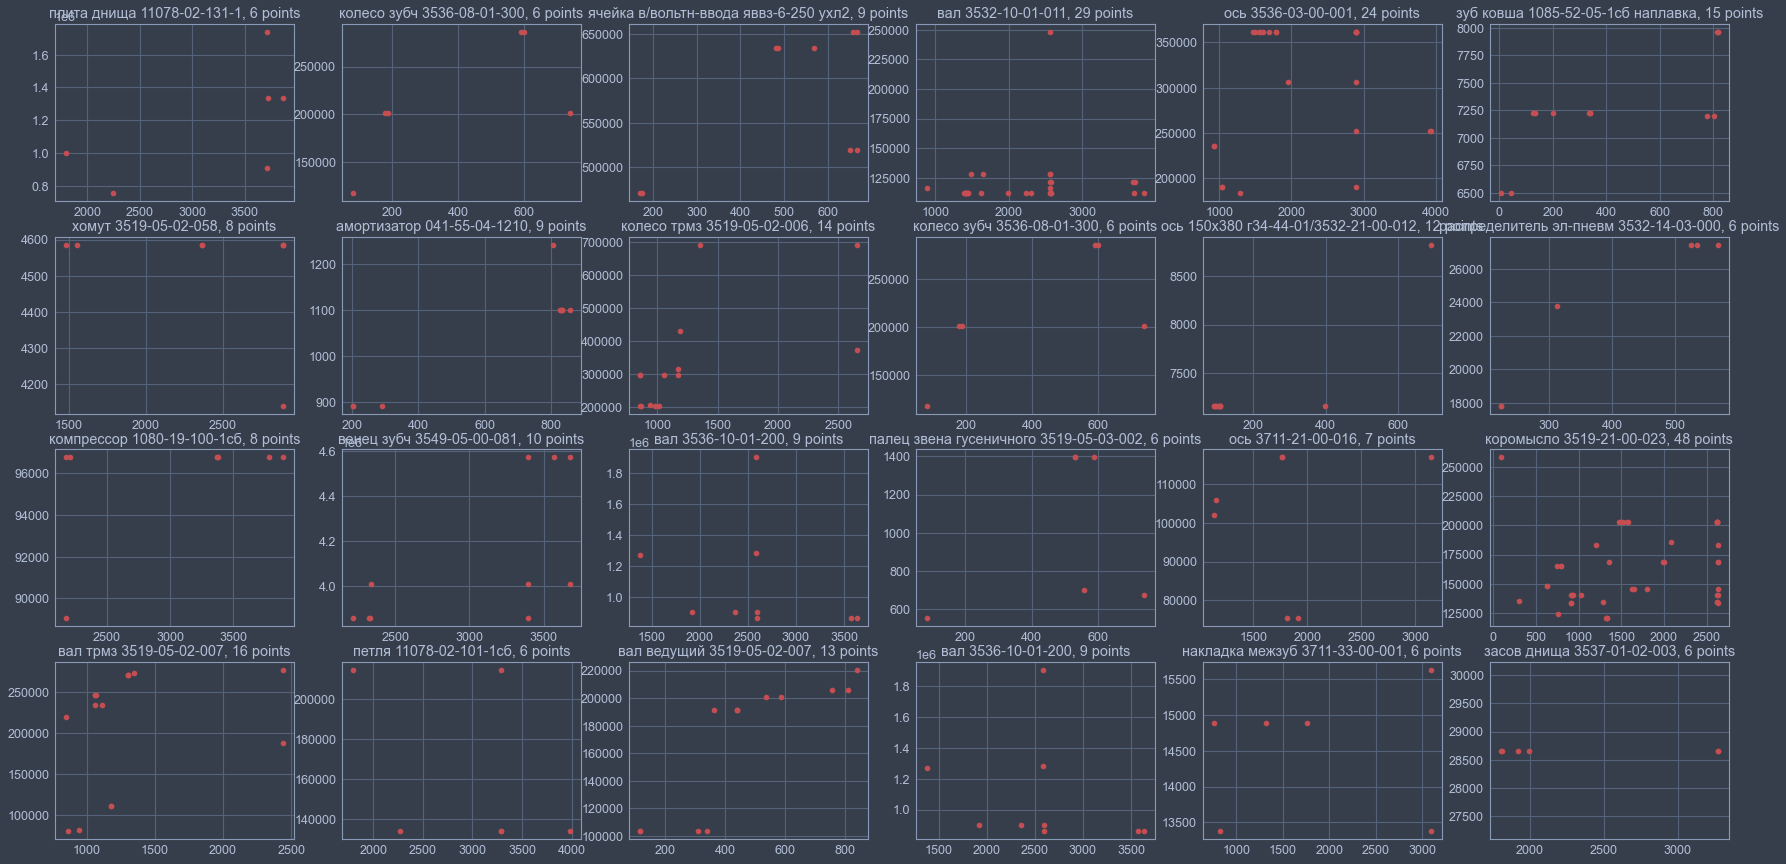

In [12]:
from random import randint
names = df_flt.name2.unique()
n_names = len(names)
N, M = 4, 6
fig, axes = plt.subplots(nrows=N, ncols=M, figsize=(30, 15))

for ax in axes.flatten():
    name_no = randint(0, n_names-1)
    name = names[name_no]
    ch_data = df_flt.price[df_flt.name2==name]
    ax.plot(ch_data.index, ch_data.values, 'ro')
    ax.title.set_text(f"{name}, {str(len(ch_data))} points")
plt.show()

In [13]:
df_flt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2520 entries, 17 to 2948
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   scheduled_delivery_period  2520 non-null   float64
 1   region                     2520 non-null   object 
 2   quantity                   2520 non-null   int64  
 3   price                      2520 non-null   float64
 4   non_scheduled              2520 non-null   float64
 5   supplier                   2520 non-null   int64  
 6   order_date_est             2520 non-null   int64  
 7   order_date_factual         2520 non-null   float64
 8   name2                      2520 non-null   object 
 9   group                      2378 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 216.6+ KB


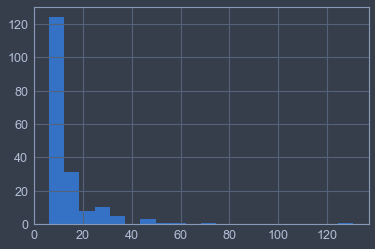

In [14]:
df_flt.groupby('name2').count().region.hist(bins=20);

## The Longest Series

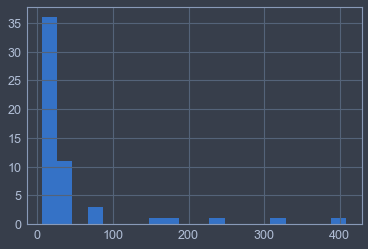

In [15]:
# group series' length histogram 
df_flt[df_flt.group.notnull()].groupby('group').count().quantity.hist(bins=20);

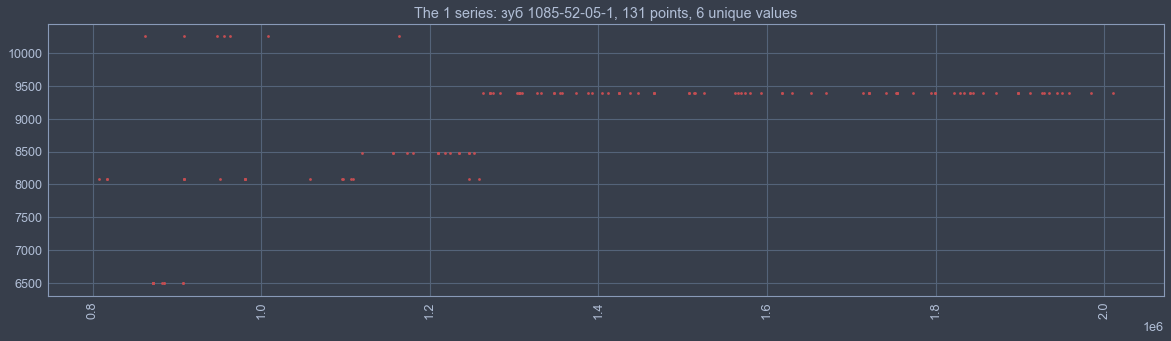

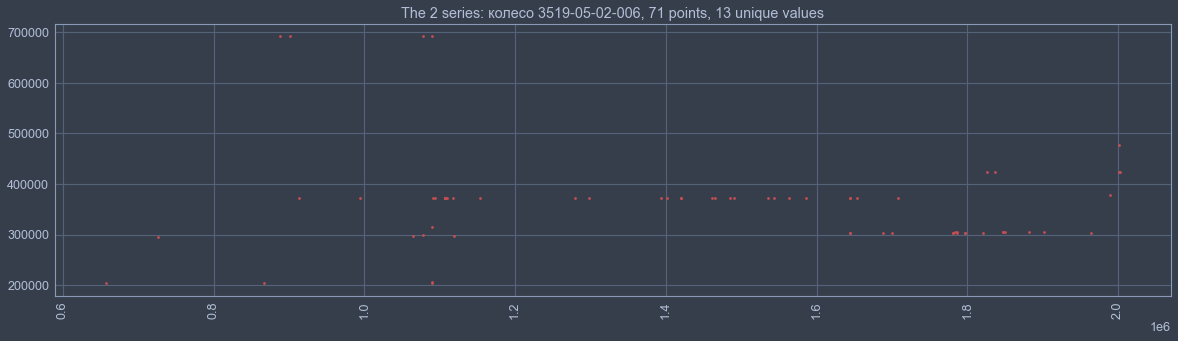

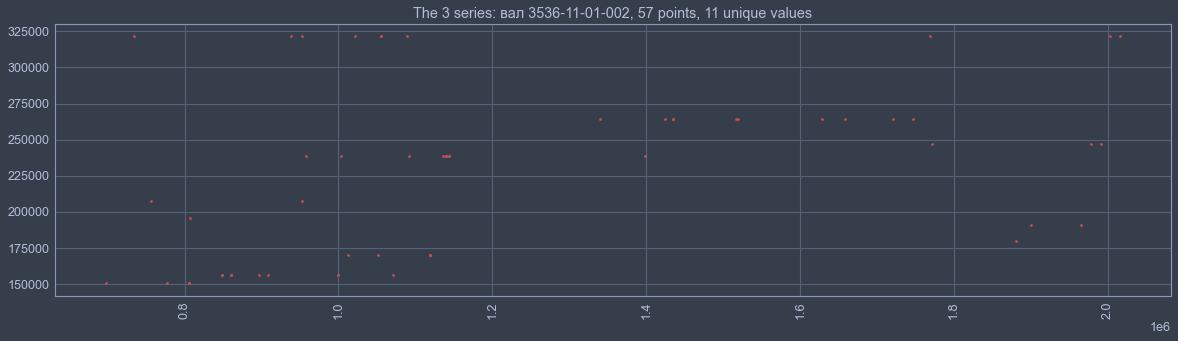

In [16]:
for i in range(3):
    name = df_flt.groupby('name2').count().region.sort_values(ascending=False).index[i]
    series = df[df.name2==name][['order_date_est', 'price']].sort_values('order_date_est', ascending=True)

    plt.figure(figsize=(20, 5))
    plt.plot(series.order_date_est, series.price, 'r.')
    plt.title(f"The {i+1} series: {name}, {len(series)} points, {series.price.nunique()} unique values")
    plt.xticks(rotation=90)
    plt.show

Looks like for many contracts there are multiple orders with the same price.

Therefore its not the order prices that need to be predicted, its contract prices.

## Transition From Orders To Contracts

In [17]:
names = df_flt.name2.unique()
df_contracts = df_flt.copy()
drop_idxs = []

for name in names:
    prices = []
    flt = df_flt[df_flt.name2==name]
    
    for i, row in flt.iterrows():
    #     import pdb; pdb.set_trace()
        if row.price in prices:
            drop_idxs.append(i)
        else:
            prices.append(row.price)
            
df_contracts.drop(index=drop_idxs, inplace=True)

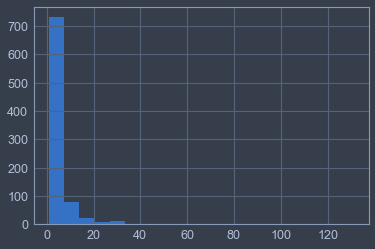

In [18]:
df.groupby('name2').count().region.hist(bins=20);

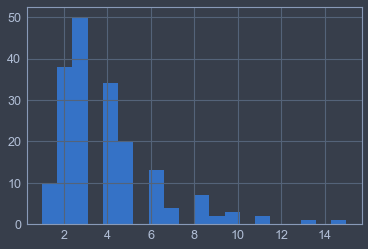

In [19]:
df_contracts.groupby('name2').count().region.hist(bins=20);

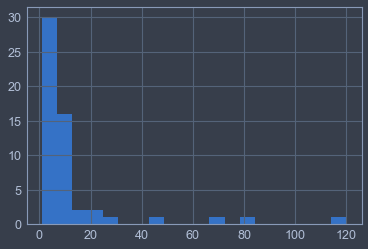

In [20]:
df_contracts.groupby('group').count().region.hist(bins=20);

In [21]:
longs_names = df_contracts.groupby('group').count().region
thresh = 40
longs_names = longs_names[longs_names.values > thresh]
longs_names

group
вал        84
втулка     45
колесо    120
ось        67
Name: region, dtype: int64

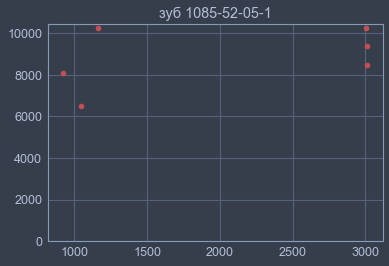

In [42]:
longest_series_name = df_flt.groupby('name2').count().region.sort_values(ascending=False).index[0]
ch_data = df_contracts[df_contracts.name2==longest_series_name].price
plt.plot(ch_data.index, ch_data.values, 'ro')
plt.title(longest_series_name)
lims = plt.axis()
plt.axis((lims[0], lims[1], 0, lims[3]));

This chart cannot be predicted accurately.

### Conclusion
After cleaning repeated prices no single item series is long enough for time series prediction.

There are 3 options:

1. Group by `group` and work with a few longest series using time-series analysis.
2. Use `order_date` as a feature and apply regular regression models.
3. Impute missing datapoints.

The odds are that 2nd option won't be able to predict consistently for new contracts if the last price date is long in the past.  
Need to study appicable approaches more before deciding on it.

Will try 1st option for now.

Option 3 is also worth trying. Will do it 2nd.

TODO: Look into irregular time series regression technics

TODO: Try different lead periods for all macro indicators or different lead times for different indicators.

## Overall Price Index

In [23]:
frequencies = df_contracts.groupby('name2').count().region.sort_values()
freqs2 = frequencies[frequencies.values>1]

In [24]:
freqs2

name2
втулка 1080-33-18-1          2
втулка 3546-03-01-008        2
втулка 1080-33-81            2
палец 00-3712-ур20км         2
втулка 1080-05-312           2
                            ..
вал трмз 3519-05-02-007     10
вал 3536-11-01-002          11
вал 3519-05-02-083          11
колесо 3519-05-02-006       13
коромысло 3519-21-00-023    15
Name: region, Length: 175, dtype: int64

TODO: try use series longer then 3 or more to build the OPI.

In [25]:
df_contracts.columns

Index(['scheduled_delivery_period', 'region', 'quantity', 'price',
       'non_scheduled', 'supplier', 'order_date_est', 'order_date_factual',
       'name2', 'group'],
      dtype='object')

In [26]:
df_contracts.describe()

,scheduled_delivery_period,quantity,price,non_scheduled,supplier,order_date_est,order_date_factual
count,732.000000,732.000000,7.320000e+02,732.000000,732.000000,7.320000e+02,732.000000
mean,177.800546,6.318306,4.528960e+05,0.062842,3876.267760,1.043143e+06,0.587432
std,81.049113,24.813858,8.976218e+05,0.242844,367.727412,4.953088e+05,0.492633
min,30.000000,1.000000,5.522293e+02,0.000000,259.000000,4.752000e+04,0.000000
25%,110.000000,1.000000,4.455414e+04,0.000000,3927.000000,7.490880e+05,0.000000
50%,180.000000,2.000000,1.710191e+05,0.000000,4011.000000,1.000080e+06,1.000000
75%,220.000000,4.000000,4.384914e+05,0.000000,4012.000000,1.306152e+06,1.000000
max,400.000000,529.000000,7.967586e+06,1.000000,4014.000000,2.016576e+06,1.000000


Will use only factual dates.

In [27]:
min_date = df_contracts[df_contracts.order_date_factual==1].order_date_est.min()
max_date = df_contracts[df_contracts.order_date_factual==1].order_date_est.max()

In [28]:
df_contracts.columns

Index(['scheduled_delivery_period', 'region', 'quantity', 'price',
       'non_scheduled', 'supplier', 'order_date_est', 'order_date_factual',
       'name2', 'group'],
      dtype='object')

In [29]:
dates = range(min_date, max_date + 1)
tseries = pd.DataFrame(index=dates)

In [30]:
df_contracts.head()

,scheduled_delivery_period,region,quantity,price,non_scheduled,supplier,order_date_est,order_date_factual,name2,group
17,120.0,Вологодская область,2,57324.840764,0.0,3699,47520,1.0,рейка зубч 1080-04-114-1 кремальерная,рейка
12,140.0,Вологодская область,5,5732.484076,0.0,3699,47520,1.0,зуб ковша 1080-02-10 наплавка,зуб
9,130.0,Вологодская область,2,9171.974522,0.0,3699,47520,1.0,вал 1080-33-51,вал
4,75.0,Вологодская область,30,6496.815287,0.0,3699,47520,1.0,зуб ковша 1085-52-05-1сб наплавка,зуб
5,90.0,Вологодская область,10,1942.675159,0.0,3699,47520,1.0,пластина ibr130 23х130х240,пластина


In [31]:
for name in freqs2.index:
#     import pdb; pdb.set_trace()
    flt = df_contracts[df_contracts.name2==name]
    for _, item in flt.iterrows():
        tseries[name] = None
        tseries.loc[item.order_date_est, name] = item.price

C:\Users\kan\AppData\Local\Temp/ipykernel_20408/717599265.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tseries[name] = None


In [32]:
tseries.head()

,втулка 1080-33-18-1,втулка 3546-03-01-008,втулка 1080-33-81,палец 00-3712-ур20км,втулка 1080-05-312,палец 01-3712-ур20км,венец зубч (1/4 часть) 3533-05-00-081,ось напорная 3546-03-04-002,втулка 3546-03-01-008р,засов днища 11078-51-154сб,...,вал 3519-05-02-007,коромысло 3537-25-00-500,сателлит 3536-11-01-028,засов 3532-01-02-007,колесо 3519-05-02-100,вал трмз 3519-05-02-007,вал 3536-11-01-002,вал 3519-05-02-083,колесо 3519-05-02-006,коромысло 3519-21-00-023
47520,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
47521,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
47522,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
47523,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
47524,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [34]:
for col in tseries.columns:
    opened = False
    npoints = tseries[col].count()
    print(f"{col=}, {npoints=}")

col='втулка 1080-33-18-1', npoints=1
col='втулка 3546-03-01-008', npoints=1
col='втулка 1080-33-81', npoints=1
col='палец 00-3712-ур20км', npoints=1
col='втулка 1080-05-312', npoints=1
col='палец 01-3712-ур20км', npoints=1
col='венец зубч (1/4 часть) 3533-05-00-081', npoints=1
col='ось напорная 3546-03-04-002', npoints=1
col='втулка 3546-03-01-008р', npoints=1
col='засов днища 11078-51-154сб', npoints=1
col='муфта 3536-22-00-400', npoints=1
col='лестница 3550-17-03-200-01', npoints=1
col='зуб ковша 1080-02-10 наплавка', npoints=1
col='лента гусеничная 3537-69-13-000 ис-09сб', npoints=1
col='зуб ковша 3711-33-00-006', npoints=1
col='ковш 1085-52-00-2сб', npoints=1
col='компрессор 1080-19-100-1сб', npoints=1
col='кольцо 3536-05-02-004', npoints=1
col='колесо натяжное 3536-05-02-300', npoints=1
col='колесо ведущ 3519-05-02-061', npoints=1
col='колесо 3519-05-02-100 малое опорное', npoints=1
col='колесо 3572-05-10-302 сателлит', npoints=1
col='ось 150х380 г34-44-01/3532-21-00-012', npoints

## Group & Normalize Longest Series

# Baseline

In [29]:
enc = OneHotEncoder(drop='first')
enc.fit(df_flt[['region', 'non_scheduled', 'supplier', 'order_date_factual', 'name2', 'group']])
encoder_df = pd.DataFrame(enc.fit_transform(df_flt[['region', 'non_scheduled', 'supplier', 'order_date_factual', 'name2']]).toarray())

In [30]:
df_enc = df[['scheduled_delivery_period', 'quantity', 'price', 'order_date_est']].join(encoder_df)
df_enc.head()

,scheduled_delivery_period,quantity,price,order_date_est,0,1,2,3,4,5,...,206,207,208,209,210,211,212,213,214,215
0,210.0,1,38394.904459,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,60.0,1,134394.904459,47520,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,60.0,1,15286.624204,47520,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,90.0,1,142038.216561,47520,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,120.0,2,57324.840764,47520,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
X, y = df_enc.drop(columns='price'), df_enc.price

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
xgb = xg.XGBRegressor(objective='reg:squarederror', n_estimators=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_ratios = y_pred / y_test

np.sqrt(MSE(np.ones(len(test_ratios)), test_ratios))

135.60457526918182

In [34]:
xgb = xg.XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_ratios = y_pred / y_test

np.sqrt(MSE(np.ones(len(test_ratios)), test_ratios))

551.9288790663921

In [35]:
xgb = xg.XGBRegressor(objective='reg:squarederror', n_estimators=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_ratios = y_pred / y_test

np.sqrt(MSE(np.ones(len(test_ratios)), test_ratios))

135.60457526918182

In [36]:
xgb = xg.XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_ratios = y_pred / y_test

np.sqrt(MSE(np.ones(len(test_ratios)), test_ratios))

551.9288790663921

In [37]:
xgb = xg.XGBRegressor(objective='reg:squarederror', n_estimators=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_ratios = y_pred / y_test

np.sqrt(MSE(np.ones(len(test_ratios)), test_ratios))

135.60457526918182

In [38]:
xgb = xg.XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_ratios = y_pred / y_test

np.sqrt(MSE(np.ones(len(test_ratios)), test_ratios))

551.9288790663921